In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import warnings
warnings.filterwarnings('ignore')

print("Kutuphaneler yuklendi")

Kutuphaneler yuklendi


In [2]:
df = pd.read_csv("hatalı.csv")
# Feature engineering (hizli)
from sklearn.preprocessing import StandardScaler

scaler_time = StandardScaler()
scaler_amount = StandardScaler()
df['Time_Scaled'] = scaler_time.fit_transform(df[['Time']])
df['Amount_Scaled'] = scaler_amount.fit_transform(df[['Amount']])

df['Amount_Log'] = np.log1p(df['Amount'])
df['Is_Small_Amount'] = (df['Amount'] < 10).astype(int)
df['Is_Large_Amount'] = (df['Amount'] > 200).astype(int)

df['Time_Hours'] = df['Time'] / 3600
df['Hour'] = (df['Time_Hours'] % 24).astype(int)
df['Is_Night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)

df['V17_V14'] = df['V17'] * df['V14']
df['Top5_sum'] = df['V17'] + df['V14'] + df['V12'] + df['V10'] + df['V16']

# Features
features = [
    'Time_Scaled', 'Amount_Scaled',
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
    'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Amount_Log', 'Is_Small_Amount', 'Is_Large_Amount',
    'Hour', 'Is_Night', 'V17_V14', 'Top5_sum'
]

X = df[features]
y = df['Class']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Final model egit
final_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
final_model.fit(X_train, y_train)

# Tahminler
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print(f"Model egitildi!")
print(f"Test AUC: {roc_auc_score(y_test, y_proba):.4f}")

Model egitildi!
Test AUC: 0.9750


In [3]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nAciklama:")
print(f"True Negative (dogru legitimate): {cm[0,0]}")
print(f"False Positive (yanlis alarm): {cm[0,1]}")
print(f"False Negative (kacan fraud): {cm[1,0]}")
print(f"True Positive (yakalanan fraud): {cm[1,1]}")

Confusion Matrix:
[[55358  1506]
 [    8    90]]

Aciklama:
True Negative (dogru legitimate): 55358
False Positive (yanlis alarm): 1506
False Negative (kacan fraud): 8
True Positive (yakalanan fraud): 90


In [4]:
# classification report (otomatik hesaplar!)
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962



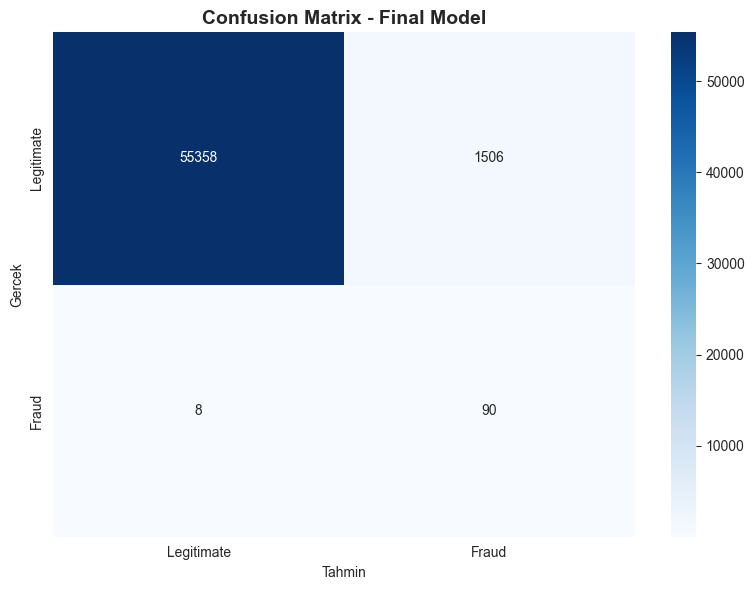


Key Metrics:
Fraud Recall (Yakalama orani): 91.8%
Fraud Kacan: 8 (8.2%)
Yanlis Alarm: 1506 (2.6%)


In [5]:
# confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix - Final Model', fontsize=14, fontweight='bold')
plt.ylabel('Gercek')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.show()

print("\nKey Metrics:")
print(f"Fraud Recall (Yakalama orani): {90/98:.1%}")
print(f"Fraud Kacan: {8} ({8/98:.1%})")
print(f"Yanlis Alarm: {1506} ({1506/56864:.1%})")

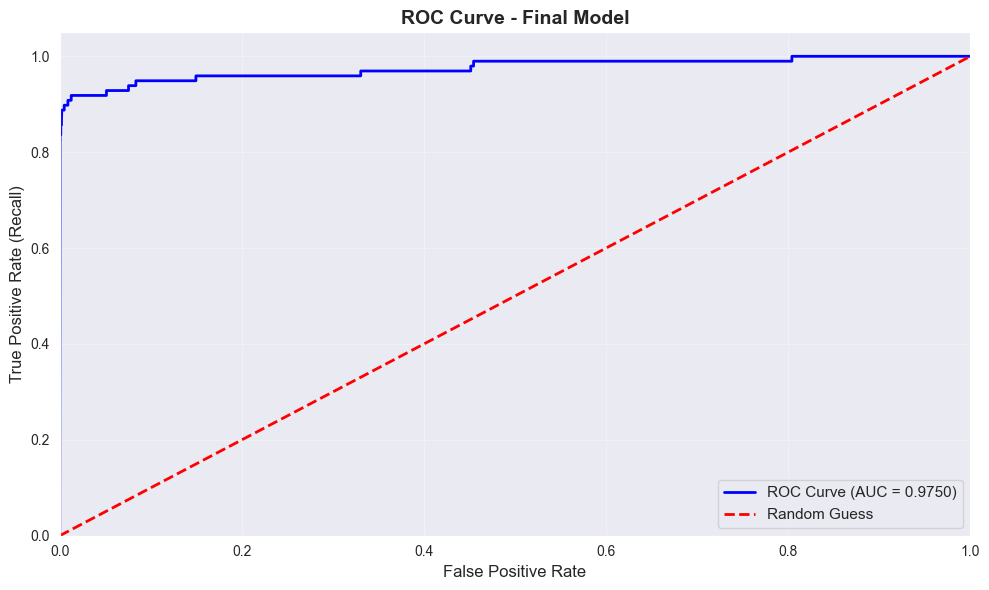

ROC-AUC Score: 0.9750


In [6]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Final Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

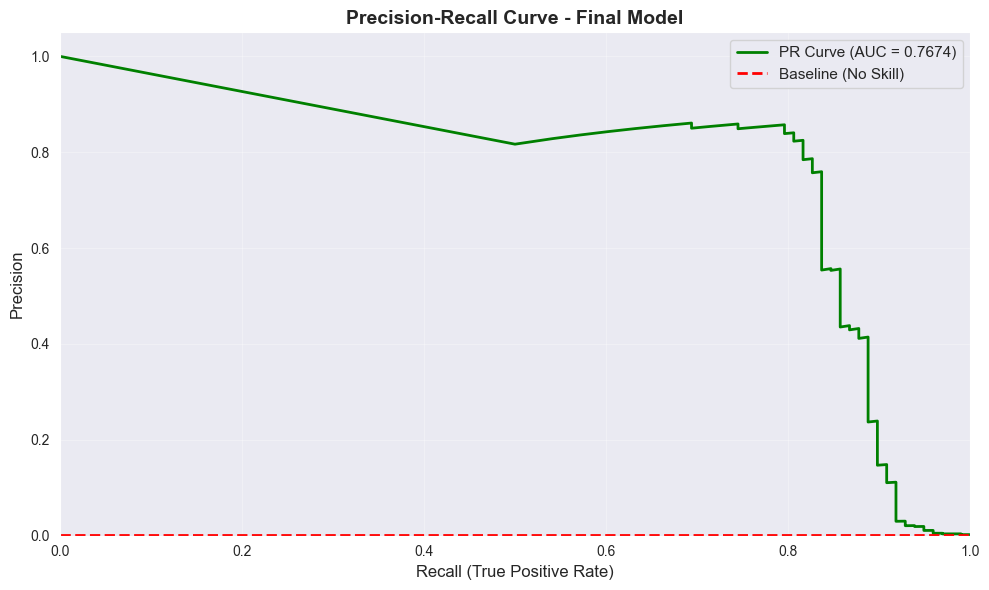

Precision-Recall AUC: 0.7674
Baseline (fraud ratio): 0.0017


In [7]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=98/56962, color='red', linestyle='--', lw=2, label='Baseline (No Skill)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (True Positive Rate)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Final Model', fontsize=14, fontweight='bold')
plt.legend(loc="upper right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Baseline (fraud ratio): {98/56962:.4f}")

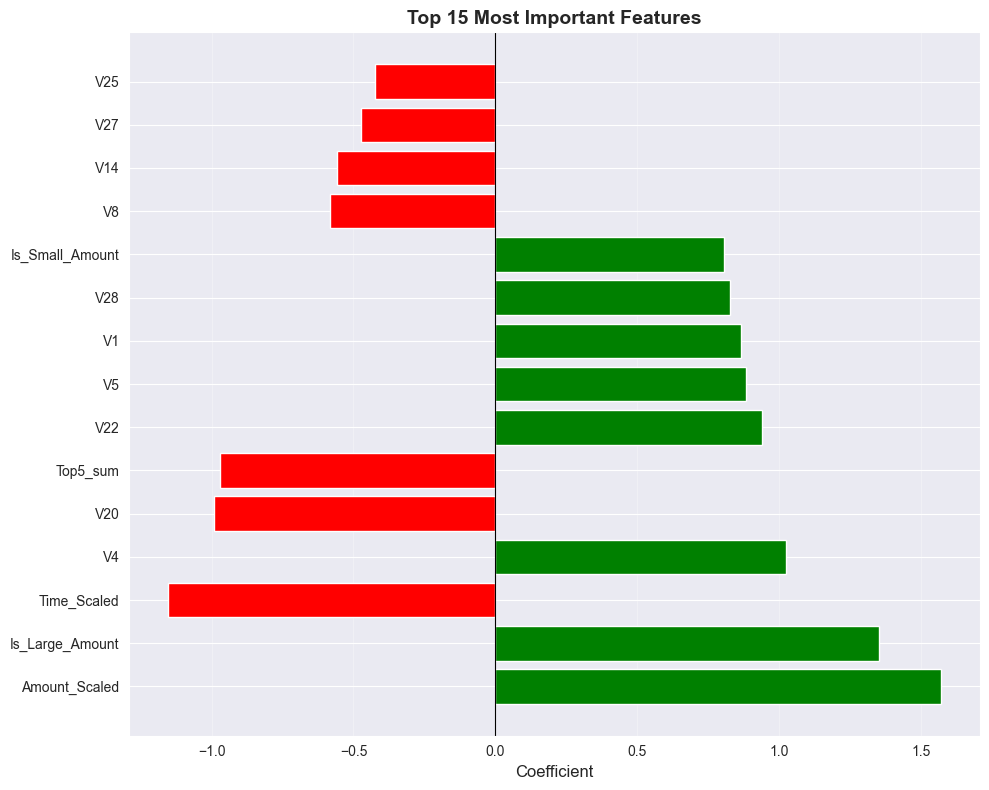

Top 10 En Onemli Feature'lar:
Amount_Scaled       :  1.5707
Is_Large_Amount     :  1.3508
Time_Scaled         : -1.1536
V4                  :  1.0253
V20                 : -0.9906
Top5_sum            : -0.9697
V22                 :  0.9378
V5                  :  0.8814
V1                  :  0.8649
V28                 :  0.8254


In [8]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': final_model.coef_[0]
})

# Mutlak deger'e gore sirala (negatif de onemli!)
feature_importance['abs_coef'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

# Top 15
top_15 = feature_importance.head(15)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in top_15['coefficient']]
plt.barh(range(len(top_15)), top_15['coefficient'], color=colors)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Coefficient', fontsize=12)
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Top 10 En Onemli Feature'lar:")
print("="*50)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:20s}: {row['coefficient']:7.4f}")

# Model Evaluation - Final Results

## Model Performance

**Final Model:** Logistic Regression
**Features:** 37 (30 original + 7 engineered)

### Key Metrics

| Metric | Score |
|--------|-------|
| ROC-AUC | 0.9750 |
| PR-AUC | 0.7674 |
| Fraud Recall | 91.8% |
| Fraud Precision | 5.6% |

## Confusion Matrix Results
```
                Tahmin
             Legit    Fraud
Gercek Legit 55,358   1,506  (2.6% yanlis alarm)
       Fraud      8      90  (91.8% yakalama)
```

**Critical Metrics:**
- **Fraud yakalanan:** 90/98 (91.8%)
- **Fraud kacan:** 8/98 (8.2%)
- **Yanlis alarm:** 1,506/56,864 (2.6%)

### Business Impact

**Iyi Taraflar:**
- %91.8 fraud yakalama orani (cok yuksek!)
- Sadece 8 fraud kacti (kabul edilebilir)
- Financial loss minimize edildi

**Dikkat Edilmesi Gerekenler:**
- 1,506 yanlis alarm var
- Musteri deneyimini etkileyebilir
- Manuel inceleme ile cozilebilir

## Top 10 Most Important Features

1. **Amount_Scaled** (+1.57) - Tutar bilgisi en onemli!
2. **Is_Large_Amount** (+1.35) - Buyuk tutarlar fraud icin kritik
3. **Time_Scaled** (-1.15) - Zamansal pattern var
4. **V4** (+1.03)
5. **V20** (-0.99)
6. **Top5_sum** (-0.97) - V interactions basarili!
7. **V22** (+0.94)
8. **V5** (+0.88)
9. **V1** (+0.86)
10. **V28** (+0.83)

### Feature Engineering Impact

Olusturdugumuz feature'lardan **4 tanesi Top 10'da:**
- Amount_Scaled (#1)
- Is_Large_Amount (#2)
- Time_Scaled (#3)
- Top5_sum (#6)

**Feature engineering basarili oldu!**

## Model Kararlari

**Threshold Optimization:**
- Default threshold (0.5) kullanildi
- Fraud Recall: 91.8%
- Production'da threshold dusurulebilir (daha cok fraud yakalamak icin)

**Trade-off:**
- Dusuk threshold → Daha cok fraud yakalar, ama yanlis alarm artar
- Yuksek threshold → Daha az yanlis alarm, ama fraud kacar
- Business ihtiyacina gore ayarlanmali

---
